### Imports

In [1]:
import io
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import shutil
import statsmodels.api as sm
import tarfile

from utils.loading import read_data_from_tar,\
    read_multiple,\
    clean_extracts
from utils.loading import ALL_DATA_FILES, TAR_FILE_PATH

In [47]:
dff = pd.read_parquet('data/2009-12-01-SPY.P-trade.parquet')

dff.sample(5)

,xltime,trade-price,trade-volume,trade-stringflag,trade-rawflag
27961,40148.647507,111.15,100,uncategorized,[CTS_QUAL ]MSW ...
28781,40148.650587,110.96,100,uncategorized,[CTS_QUAL ] ...
32461,40148.666953,111.06,200,uncategorized,[CTS_QUAL ] ...
10968,40148.614600,111.13,200,uncategorized,[CTS_QUAL ]MSW ...
10700,40148.614355,111.12,300,uncategorized,[CTS_QUAL ]MSW ...


### Data sanity check

It appears that the columns are non-null. But, some parquet files are corrupted and we need to remove them.

In [2]:
def is_valid_parquet_file(file_obj, file_size):
    if file_size < 8:
        return False  # File is too small to be a valid Parquet file

    try:
        start_magic = file_obj.read(4)

        file_obj.seek(-4, io.SEEK_END)
        end_magic = file_obj.read(4)

        return start_magic == b'PAR1' and end_magic == b'PAR1'
    except Exception as e:
        print(f"Error checking file: {e}")
        return False

def check_parquet_files_in_tar(tar_file_path):
    corrupted_files = []
    with tarfile.open(tar_file_path, 'r') as tar:
        for member in tar.getmembers():
            if member.isfile() and member.name.endswith('.parquet'):
                file_obj = tar.extractfile(member)
                if file_obj:
                    if not is_valid_parquet_file(file_obj, member.size):
                        print(f"Potential corruption detected in: {member.name}")
                        corrupted_files.append(member.name)
    return corrupted_files

In [3]:
CORRUPTED_FILES = check_parquet_files_in_tar(TAR_FILE_PATH)
DATA_FILES = [f for f in ALL_DATA_FILES if f not in CORRUPTED_FILES]

Potential corruption detected in: TRTH/clean/fut/US/bbo/chain/ES/2010-02-16-ES-bbo_month_chain.parquet
Potential corruption detected in: TRTH/clean/fut/US/bbo/chain/ES/2002-07-23-ES-bbo_month_chain.parquet
Potential corruption detected in: TRTH/clean/fut/US/bbo/chain/ES/2002-08-01-ES-bbo_month_chain.parquet


In [8]:
df = read_data_from_tar(np.random.choice(DATA_FILES))

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1087172 entries, 0 to 1087171
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype                           
---  ------  --------------    -----                           
 0   index   1087172 non-null  datetime64[ns, America/New_York]
 1   bid     1087172 non-null  float64                         
 2   bidQ    1087172 non-null  float64                         
 3   ask     1087172 non-null  float64                         
 4   askQ    1087172 non-null  float64                         
dtypes: datetime64[ns, America/New_York](1), float64(4)
memory usage: 41.5 MB


### Trading impact analysis

In [53]:
df_day = df.copy()

if "index" in df_day.columns:
    df_day['index'] = pd.to_datetime(df_day['index'])
    df_day.set_index('index', inplace=True)

df_day['trade_size'] = df_day[['bidQ', 'askQ']].diff().abs().sum(axis=1)
df_day['mid_price'] = (df_day['bid'] + df_day['ask']) / 2
df_day['price_impact'] = df_day['mid_price'].diff().abs()

TRADE_SIZE_THRESHOLD = 1000

df_day = df_day[df_day['trade_size'] > TRADE_SIZE_THRESHOLD]

df_day.sample(10)

,bid,bidQ,ask,askQ,trade_size,mid_price,price_impact
index,,,,,,,
2009-02-04 10:10:44.015999-05:00,232.524543,403.0,232.593195,24.0,1522.0,232.558869,0.068652
2009-02-04 15:50:01.453000-05:00,227.512942,784.0,227.581594,9.0,1017.0,227.547268,0.068652
2009-02-04 13:42:01.960000-05:00,228.954635,1365.0,229.023288,14.0,1277.0,228.988962,0.068652
2009-02-04 10:29:10.336000-05:00,232.524543,568.0,232.593195,16.0,1140.0,232.558869,0.068652
2009-02-04 14:38:58.118000-05:00,227.856202,848.0,227.924855,6.0,1108.0,227.890528,0.068652
2009-02-04 10:52:19.537000-05:00,232.112630,324.0,232.181283,4.0,1046.0,232.146956,0.068652
2009-02-04 11:38:59.535999-05:00,231.769370,864.0,231.838022,52.0,1060.0,231.803696,0.068652
2009-02-04 11:22:15.517000-05:00,231.769370,1224.0,231.906674,298.0,1206.0,231.838022,0.034326
2009-02-04 09:55:44.116000-05:00,231.563414,500.0,231.632066,40.0,1576.0,231.597740,0.068652


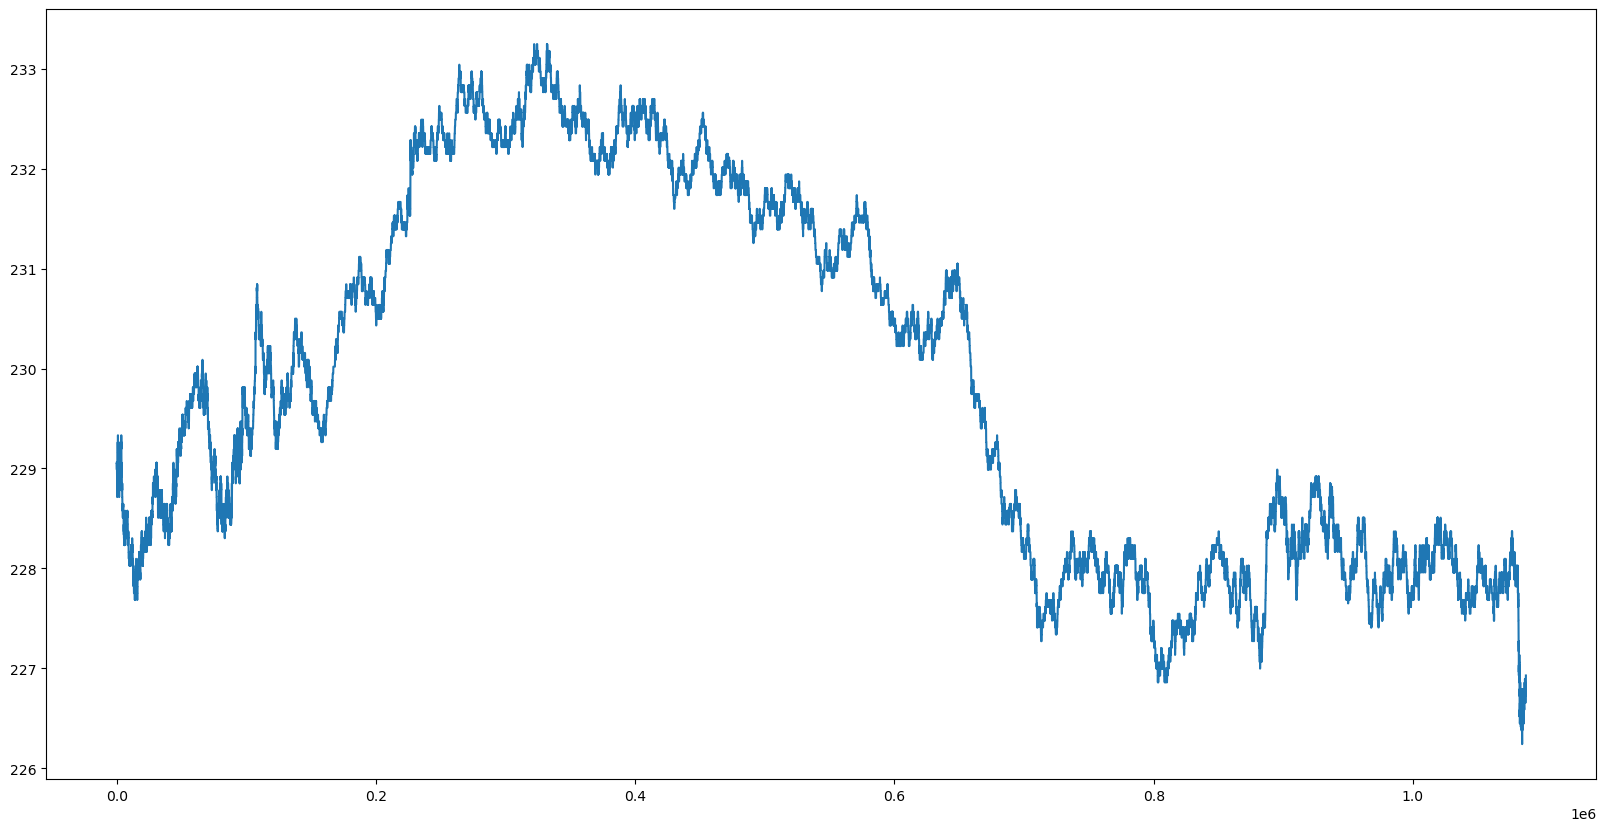

In [73]:
df[['bid', 'ask']].sum(axis=1).apply(lambda x: x/2).plot(figsize=(20, 10))
plt.show()

In [68]:
df_day.sort_values('price_impact', ascending=False).head(10)

,bid,bidQ,ask,askQ,trade_size,mid_price,price_impact
index,,,,,,,
2009-02-04 08:34:45.278000-05:00,230.259025,1168.0,230.327677,147.0,1028.0,230.293351,0.343260
2009-02-04 14:48:47.528000-05:00,227.718898,87.0,227.787550,906.0,1071.0,227.753224,0.137304
2009-02-04 10:28:51.168999-05:00,232.455891,446.0,232.524543,1.0,1097.0,232.490217,0.137304
2009-02-04 10:28:51.168999-05:00,232.593195,14.0,232.661847,666.0,1002.0,232.627521,0.137304
2009-02-04 09:40:23.140000-05:00,230.190373,124.0,230.259025,805.0,1013.0,230.224699,0.137304
2009-02-04 12:25:38.717000-05:00,231.082849,675.0,231.151502,1203.0,1060.0,231.117176,0.137304
2009-02-04 15:36:27.543999-05:00,228.130811,20.0,228.199463,239.0,1039.0,228.165137,0.137304
2009-02-04 15:01:14.610999-05:00,228.268115,900.0,228.336767,23.0,1237.0,228.302441,0.137304
2009-02-04 15:36:11.724999-05:00,228.130811,41.0,228.199463,694.0,1002.0,228.165137,0.137304


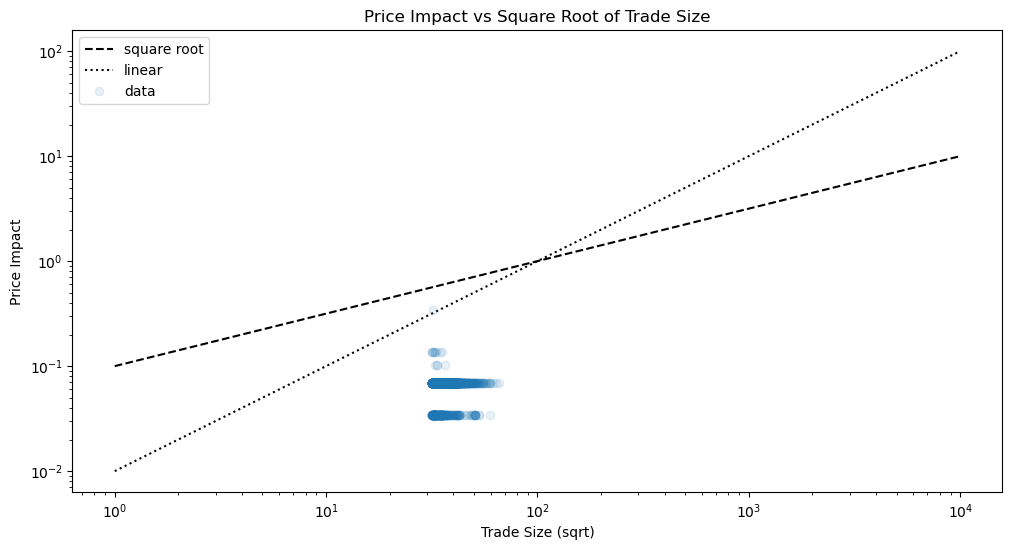

In [62]:
plt.figure(figsize=(12, 6))
x = np.linspace(1, 10000, 100)
plt.loglog(x, 0.1 * x ** 0.5, 'k--', label='square root')
plt.loglog(x, 0.01 * x, 'k:', label='linear')
plt.loglog(df_day['trade_size'].apply(np.sqrt), df_day['price_impact'], 'o', alpha=0.1, label='data')
plt.xlabel('Trade Size (sqrt)')
plt.ylabel('Price Impact')
plt.title('Price Impact vs Square Root of Trade Size')
plt.legend()
plt.show()

<Axes: ylabel='Frequency'>

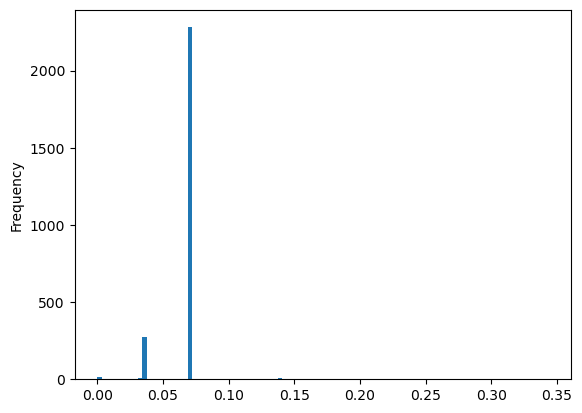

In [12]:
df_day.price_impact.plot.hist(bins=100)

In [13]:
# Example of binning trade sizes into quartiles for simplicity
df_day['trade_size_bin'] = pd.qcut(df_day['trade_size'], 4, labels=False)

df_day.sample(10)

,bid,bidQ,ask,askQ,trade_size,mid_price,price_impact,trade_size_bin
index,,,,,,,,
2009-02-04 10:06:37.137000-05:00,232.318587,32.0,232.387239,70.0,1056.0,232.352913,0.068652,0
2009-02-04 10:01:27.544000-05:00,232.387239,582.0,232.455891,23.0,1085.0,232.421565,0.068652,0
2009-02-04 15:50:31.360999-05:00,227.650246,736.0,227.718898,4.0,1584.0,227.684572,0.068652,3
2009-02-04 13:39:08.904000-05:00,229.709808,46.0,229.778460,540.0,1742.0,229.744134,0.068652,3
2009-02-04 10:23:21.745000-05:00,232.181283,733.0,232.249935,2.0,2258.0,232.215609,0.068652,3
2009-02-04 12:28:24.151000-05:00,231.082849,44.0,231.151502,987.0,1474.0,231.117176,0.068652,3
2009-02-04 10:59:55.274000-05:00,232.593195,880.0,232.661847,266.0,1253.0,232.627521,0.068652,2
2009-02-04 15:58:12.436999-05:00,227.650246,1352.0,227.718898,188.0,1547.0,227.684572,0.068652,3
2009-02-04 09:45:16.190000-05:00,231.082849,4.0,231.151502,816.0,1182.0,231.117176,0.068652,1


<Axes: ylabel='Frequency'>

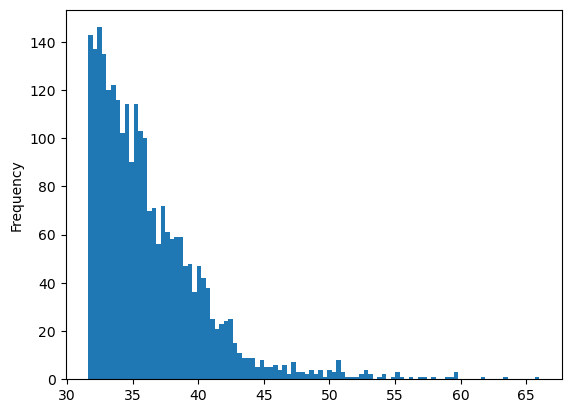

In [24]:
np.sqrt(df_day['trade_size']).plot.hist(bins=100)

In [26]:
df_day['log_return'] = np.log(df_day['mid_price'] / df_day['mid_price'].shift(1))

# Group by date and calculate daily volatility
daily_volatility = df_day['log_return'].std()
volume = df_day["trade_size"].sum()

print(f"std: {daily_volatility}")
print(f"volume: {volume}")

std: 0.00046599194243304964
volume: 3468678.0


In [28]:
df_test = df_day.copy()
# df_test = df_test[df_test["significant_askQ_change"] | df_test["significant_bidQ_change"]]

In [32]:
df_test

,bid,bidQ,ask,askQ,trade_size,mid_price,price_impact,trade_size_bin,sqrt_trade_size,log_return,q/v
index,,,,,,,,,,,
2009-02-04 03:58:48.538000-05:00,228.542723,3.0,228.611375,706.0,1043.0,228.577049,0.068652,0,32.295511,NaN,0.000301
2009-02-04 03:59:05.952000-05:00,228.474071,383.0,228.542723,10.0,1022.0,228.508397,0.068652,0,31.968735,-0.000300,0.000295
2009-02-04 08:34:45.278000-05:00,230.259025,1168.0,230.327677,147.0,1028.0,230.293351,0.343260,0,32.062439,0.007781,0.000296
2009-02-04 08:34:45.366000-05:00,230.327677,5.0,230.396329,343.0,1123.0,230.362003,0.068652,1,33.511192,0.000298,0.000324
2009-02-04 08:34:45.399999-05:00,230.259025,804.0,230.327677,1.0,1136.0,230.293351,0.068652,1,33.704599,-0.000298,0.000328
...,...,...,...,...,...,...,...,...,...,...,...
2009-02-04 16:07:02.548999-05:00,227.650246,1031.0,227.787550,198.0,1020.0,227.718898,0.034326,0,31.937439,-0.001356,0.000294
2009-02-04 16:07:04.006999-05:00,227.650246,961.0,227.718898,64.0,1076.0,227.684572,0.068652,0,32.802439,-0.000151,0.000310
2009-02-04 16:07:04.166999-05:00,227.718898,43.0,227.787550,239.0,1149.0,227.753224,0.068652,1,33.896903,0.000301,0.000331


In [34]:
df_test["q/v"] = df_test["trade_size"] / volume
df_test["spread/std"] = df_test["price_impact"] / daily_volatility